<a href="https://colab.research.google.com/github/SauravTelge/eecs504/blob/main/EECS442_504_PS4_FA_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 442/504 PS4: Backpropagation

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Saurav Telge, sauravt

__Important__: after you download the .ipynb file, please name it as __"PS\<this_ps_number\>_\<your_uniqname\>.ipynb"__ before you submit it to canvas. Example: adam_01101100.ipynb.




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from torchvision.datasets import CIFAR10
download = not os.path.isdir('cifar-10-batches-py')
dset_train = CIFAR10(root='.', download=download)


In [2]:
import torch

# Problem 4.1 Understanding Backpropagation

# 4.1 (b)  
Implement the code for forward and backward pass of computation graph in (a)

In [3]:
def f_1(x0, x1, x2, w0, w1, w2, w3):
    """
    Computes the forward and backward pass through the computational graph 
    of (a)

    Inputs:
    - x0, x1, x2, w0, w1, w2, w3: Python floats

    Returns a tuple of:
    - L: The output of the graph
    - grads: A tuple (grad_x0, grad_x1, grad_x2, grad_w0, grad_w1, grad_w2, 
      grad_w3)
    giving the derivative of the output L with respect to each input.
    """
    ###########################################################################
    # TODO: Implement the forward pass for the computational graph for (a) and#
    # store the output of this graph as L                                     #
    ###########################################################################
  
    t1= w2/x2
    t2=w1*x1
    t3=w0*x0
    L = 1/(1+math.exp(-(t3+t2-t1+w3)))

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    
    ###########################################################################
    # TODO: Implement the backward pass for the computational graph for (a)   #
    # Store the gradients for each input                                      #
    ###########################################################################
    grad_l=1
    grad_t3= grad_l * (math.exp(-t3))/(1+math.exp(-t3))**2 
    grad_t2 = grad_l * (math.exp(-t2))/(1+math.exp(-t2))**2 
    grad_t1 = grad_l * (-math.exp(t1))/(1+math.exp(t1))**2 
    grad_x0= grad_t3* w0
    grad_x1= grad_t2 * w1 
    grad_x2= -w2/(x2**2) * grad_t1
    grad_w0= grad_t3 * x0
    grad_w1 = grad_t2 * x1
    grad_w2 =(1/x2) * grad_t1 
    grad_w3= grad_l * (math.exp(-w3))/(1+math.exp(-w3))**2 

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    grads = (grad_x0, grad_x1, grad_x2, grad_w0, grad_w1, grad_w2, grad_w3)
    return L, grads

# 4.1 (c)  
Implement the code for forward and backward pass of computation graph in (c)


In [4]:
def f_2(w, x, y, z):
    """
    Computes the forward and backward pass through the computational graph 
    of (c)

    Inputs:
    - w, x, y, z: Python floats

    Returns a tuple of:
    - L: The output of the graph
    - grads: A tuple (grad_w, grad_x, grad_y, grad_z)
    giving the derivative of the output L with respect to each input.
    """
    ###########################################################################
    # TODO: Implement the forward pass for the computational graph for (c) and#
    # store the output of this graph as L                                     #
    ###########################################################################
   
    a = 1/w
    b=-x
    e=a**b
    c=math.exp(y)
    d= math.exp(z)
    p=c*d
    f=c+p
    g=d/p
    m=e-f
    n=m/g
    L=n**2
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    ###########################################################################
    # TODO: Implement the backward pass for the computational graph for (c)   #
    # Store the gradients for each input                                      #
    ###########################################################################
    grad_l = 1
    grad_n = 2*n*grad_l
    grad_m=(1/g)*grad_n
    grad_g = (-m/g**2 )* grad_n
    grad_e = grad_m * 1
    grad_f = grad_m * -1
    grad_d1=grad_g * 1/p
    grad_p=grad_g* -d/(p**2)
    grad_c1=grad_f * 1
    grad_p = grad_f * 1
    grad_c2 = grad_p*d
    grad_d2 = grad_p*c
    grad_c = grad_c1 + grad_c2
    grad_d = grad_d1 + grad_d2
    grad_z= grad_d * math.exp(z)
    grad_y = grad_c * np.exp(y)
    grad_a= grad_e * b*(a**(b-1))
    grad_b= grad_e * (a**b) * np.log(a)
    grad_x = grad_b * -1
    grad_w = grad_a * (-1/(w**2))

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    grads = (grad_w, grad_x, grad_y, grad_z)
    return L, grads

# Problem 4.2 Softmax Classifier with Two Layer Neural Network
In this problem you will develop a two Layer neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

We train the network with a softmax loss function on the weight matrices. The network uses a ReLU nonlinearity after the first fully connected layer. In other words, the network has the following architecture:

input - fully connected layer - ReLU - fully connected layer - softmax

The outputs of the second fully-connected layer are the scores for each class.

You cannot use any deep learning libraries such as PyTorch in this part.

# 4.2 (a) Layers
In this problem, implement fully connected layer, relu and softmax. Filling in all TODOs in skeleton codes will be sufficient.

In [5]:
def fc_forward(X, W, b):
    """
    Computes the forward pass for a fully-connected layer.
    
    The input X has shape (N, Din) and contains a minibatch of N
    examples, where each example x[i] has shape (Din,).
    
    Inputs:
    - X: A numpy array containing input data, of shape (N, Din)
    - W: A numpy array of weights, of shape (Din, Dout)
    - b: A numpy array of biases, of shape (Dout,)
    
    Returns a tuple of:
    - out: output, of shape (N, Dout)
    - cache: (X, W, b)
    """
    ###########################################################################
    # TODO: Implement the forward pass. Store the result in out.              #
    ###########################################################################

    out = np.matmul(X, W) + b

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (X, W, b)
    return out, cache


def fc_backward(dout, cache):
    """
    Computes the backward pass for a fully_connected layer.
    
    Inputs:
    - dout: Upstream derivative, of shape (N, Dout)
    - cache: returned by your forward function. Tuple of:
      - X: Input data, of shape (N, Din)
      - W: Weights, of shape (Din, Dout)
      - b: Biases, of shape (Dout,)
      
    Returns a tuple of:
    - dX: Gradient with respect to X, of shape (N, Din)
    - dW: Gradient with respect to W, of shape (Din, Dout)
    - db: Gradient with respect to b, of shape (Dout,)
    """
    X, W, b = cache
    dX, dW, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################

   
    dX = np.matmul(dout,W.T)
    dW = np.matmul(X.T, dout )
    db = np.sum(dout, axis=0)



    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dX, dW, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = x.copy()
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    
    
    out[out < 0] = 0


    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x

    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: returned by your forward function. Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = dout.copy(), cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    
  
    dx[x<=0]=0

    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


def softmax_loss(X, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - X: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for X[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dX: Gradient of the loss with respect to x
    """
    loss, dX = None, None

    dX = np.exp(X - np.max(X, axis=1, keepdims=True))
    dX /= np.sum(dX, axis=1, keepdims=True)
    loss = -np.sum(np.log(dX[np.arange(X.shape[0]), y])) / X.shape[0]
    dX[np.arange(X.shape[0]), y] -= 1
    dX /= X.shape[0]


    return loss, dX

# 4.2 (b) Two Layer Softmax Classifier

In this problem, implement two layer softmax classifier.

In [12]:
class SoftmaxClassifier(object):
    """
    A fully-connected neural network with
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecture should be fc - relu - fc - softmax with one hidden layer

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3072, hidden_dim=300, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:f
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer, None
          if there's no hidden layer.
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        """
        self.params = {}
        self.reg = reg
        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with fc weights and biases using the keys        #
        # 'W' and 'b', i.e., W1, b1 for the weights and bias in the first linear   #
        # layer, W2, b2 for the weights and bias in the second linear layer.       #
        ############################################################################
        
        self.params['W1']= np.random.normal(loc=0.0, scale=weight_scale, size=(input_dim,hidden_dim ))
        self.params['W2']= np.random.normal(loc=0.0, scale=weight_scale, size=(hidden_dim,num_classes ))
        self.params['b1']= np.zeros((1,hidden_dim))
        self.params['b2']= np.zeros((1,num_classes))

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def forwards_backwards(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, Din)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass. And
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################

        out_1, cache_1 = fc_forward(X, self.params['W1'], self.params['b1'])
        out_2,cache_2=relu_forward(out_1)
        out_3, cache_3 = fc_forward(out_2, self.params['W2'], self.params['b2'])
        scores = out_3
       

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k].                                                          # 
        ############################################################################

        loss, dscores = softmax_loss(scores, y)
  

        dx_2, grads['W2'], grads['b2'] = fc_backward(dscores, cache_3)
        dx_2=relu_backward(dx_2,cache_2)
        dx_1, grads['W1'], grads['b1'] = fc_backward(dx_2, cache_1)

        grads['W2'] += self.reg*self.params['W2']
        grads['W1'] += self.reg*self.params['W1']


        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        ############################################################################
        # TODO: 4.2(g)(EECS 504 only) Add L2 regularization                        # 
        ############################################################################

        loss += 0.5*self.reg*np.sum(self.params['W1']**2) + 0.5*self.reg*np.sum(self.params['W2']**2)

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return loss, grads

  


# 4.2(c) Training

In this problem, you need to preprocess the images and set up model hyperparameters. Notice that adjust the training and val split is optional.

In [7]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding="latin1")
    return dict

def load_cifar10():
    data = {}
    meta = unpickle("cifar-10-batches-py/batches.meta")
    batch1 = unpickle("cifar-10-batches-py/data_batch_1")
    batch2 = unpickle("cifar-10-batches-py/data_batch_2")
    batch3 = unpickle("cifar-10-batches-py/data_batch_3")
    batch4 = unpickle("cifar-10-batches-py/data_batch_4")
    batch5 = unpickle("cifar-10-batches-py/data_batch_5")
    test_batch = unpickle("cifar-10-batches-py/test_batch")
    X_train = np.vstack((batch1['data'], batch2['data'], batch3['data'],\
                         batch4['data'], batch5['data']))
    Y_train = np.array(batch1['labels'] + batch2['labels'] + batch3['labels'] + 
                       batch4['labels'] + batch5['labels'])
    X_test = test_batch['data']
    Y_test = test_batch['labels']
    
    #Preprocess images here                                     
    X_train = (X_train-np.mean(X_train,axis=1,keepdims=True))/np.std(X_train,axis=1,keepdims=True)
    X_test = (X_test-np.mean(X_test,axis=1,keepdims=True))/np.std(X_test,axis=1,keepdims=True)

    data['X_train'] = X_train[:40000]
    data['y_train'] = Y_train[:40000]
    data['X_val'] = X_train[40000:]
    data['y_val'] = Y_train[40000:]
    data['X_test'] = X_test
    data['y_test'] = Y_test
    return data

def testNetwork(model, X, y, num_samples=None, batch_size=100):
    """
    Check accuracy of the model on the provided data.

    Inputs:
    - model: Image classifier
    - X: Array of data, of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,)
    - num_samples: If not None, subsample the data and only test the model
      on num_samples datapoints.
    - batch_size: Split X and y into batches of this size to avoid using
      too much memory.

    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
      classified by the model.
    """

    # Subsample the data
    N = X.shape[0]
    if num_samples is not None and N > num_samples:
        mask = np.random.choice(N, num_samples)
        N = num_samples
        X = X[mask]
        y = y[mask]

    # Compute predictions in batches
    num_batches = N // batch_size
    if N % batch_size != 0:
        num_batches += 1
    y_pred = []
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        scores = model.forwards_backwards(X[start:end])
        y_pred.append(np.argmax(scores, axis=1))
    y_pred = np.hstack(y_pred)
    acc = np.mean(y_pred == y)

    return acc

def SGD(W,dW, learning_rate=1e-3):
    """ Apply a gradient descent step on weight W 
    Inputs:
        W : Weight matrix
        dW : gradient of weight, same shape as W
        learning_rate : Learning rate. Defaults to 1e-3.
    Returns:
        new_W: Updated weight matrix
    """

    # Apply a gradient descent step on weight W using the gradient dW and the specified learning rate.
    new_W = W - learning_rate * dW

    return new_W

def trainNetwork(model, data, **kwargs):
    """
     Required arguments:
    - model: Image classifier
    - data: A dictionary of training and validation data containing:
      'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
      'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
      'y_train': Array, shape (N_train,) of labels for training images
      'y_val': Array, shape (N_val,) of labels for validation images

    Optional arguments:
    - learning_rate: A scalar for initial learning rate.
    - lr_decay: A scalar for learning rate decay; after each epoch the
      learning rate is multiplied by this value.
    - batch_size: Size of minibatches used to compute loss and gradient
      during training.
    - num_epochs: The number of epochs to run for during training.
    - print_every: Integer; training losses will be printed every
      print_every iterations.
    - verbose: Boolean; if set to false then no output will be printed
      during training.
    - num_train_samples: Number of training samples used to check training
      accuracy; default is 1000; set to None to use entire training set.
    - num_val_samples: Number of validation samples to use to check val
      accuracy; default is None, which uses the entire validation set.
    - optimizer: Choice of using either 'SGD' or 'SGD_Momentum' for updating weights; default is SGD.
    """
    
    
    learning_rate =  kwargs.pop('learning_rate', 1e-3)
    lr_decay = kwargs.pop('lr_decay', 1.0)
    batch_size = kwargs.pop('batch_size', 100)
    num_epochs = kwargs.pop('num_epochs', 10)
    num_train_samples = kwargs.pop('num_train_samples', 1000)
    num_val_samples = kwargs.pop('num_val_samples', None)
    print_every = kwargs.pop('print_every', 10)   
    verbose = kwargs.pop('verbose', True)
    optimizer = kwargs.pop('optimizer', 'SGD')
    
    epoch = 0
    best_val_acc = 0
    best_params = {}
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    
    num_train = data['X_train'].shape[0]
    iterations_per_epoch = max(num_train // batch_size, 1)
    num_iterations = num_epochs * iterations_per_epoch
    
    #Initialize velocity dictionary if optimizer is SGD_Momentum
    if optimizer == 'SGD_Momentum':
      velocity_dict = {p:np.zeros(w.shape) for p,w in model.params.items()}
      
    for t in range(num_iterations): 
        # Make a minibatch of training data
        batch_mask = np.random.choice(num_train, batch_size)
        X_batch = data['X_train'][batch_mask]
        y_batch = data['y_train'][batch_mask]
        
        # Compute loss and gradient
        loss, grads = model.forwards_backwards(X_batch, y_batch)
        loss_history.append(loss)

        # Perform a parameter update
        if optimizer == 'SGD':
          for p, w in model.params.items():
              model.params[p] = SGD(w,grads[p], learning_rate=learning_rate)

        elif optimizer == 'SGD_Momentum':
          for p, w in model.params.items():
              model.params[p], velocity_dict[p] = SGD_Momentum(w, grads[p], velocity_dict[p], beta=0.5, learning_rate=learning_rate)
        else:
          raise NotImplementedError
        # Print training loss
        if verbose and t % print_every == 0:
            print('(Iteration %d / %d) loss: %f' % (
                   t + 1, num_iterations, loss_history[-1]))
         
        # At the end of every epoch, increment the epoch counter and decay
        # the learning rate.
        epoch_end = (t + 1) % iterations_per_epoch == 0
        if epoch_end:
            epoch += 1
            learning_rate *= lr_decay
        
        # Check train and val accuracy on the first iteration, the last
        # iteration, and at the end of each epoch.
        first_it = (t == 0)
        last_it = (t == num_iterations - 1)
        if first_it or last_it or epoch_end:
            train_acc = testNetwork(model, data['X_train'], data['y_train'],
                num_samples= num_train_samples)
            val_acc = testNetwork(model, data['X_val'], data['y_val'],
                num_samples=num_val_samples)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            if verbose:
                print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                       epoch, num_epochs, train_acc, val_acc))

            # Keep track of the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {}
                for k, v in model.params.items():
                    best_params[k] = v.copy()
        
    model.params = best_params
        
    return model, train_acc_history, val_acc_history
        

# load data
data = load_cifar10() 
train_data = { k: data[k] for k in ['X_train', 'y_train', 
                                    'X_val', 'y_val']}

# initialize model
model_SGD = SoftmaxClassifier(hidden_dim = 300, weight_scale=1e-2)

#######################################################################
# TODO: Set up model hyperparameters for SGD                          #
#######################################################################

# set the hyperparameter
learning_rate_SGD = 0.1
lr_decay_SGD =learning_rate_SGD / 10
batch_size_SGD = 64

# start training using SGD
model_SGD, train_acc_history_SGD, val_acc_history_SGD = trainNetwork(
    model_SGD, train_data, 
    learning_rate = learning_rate_SGD,
    lr_decay=lr_decay_SGD, 
    batch_size=batch_size_SGD,
    num_epochs=10, 
    print_every=1000, optimizer = 'SGD')
#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################


(Iteration 1 / 6250) loss: 2.308494
(Epoch 0 / 10) train acc: 0.160000; val_acc: 0.159500
(Epoch 1 / 10) train acc: 0.415000; val_acc: 0.408200
(Iteration 1001 / 6250) loss: 1.272120
(Epoch 2 / 10) train acc: 0.528000; val_acc: 0.478900
(Epoch 3 / 10) train acc: 0.531000; val_acc: 0.479400
(Iteration 2001 / 6250) loss: 1.280092
(Epoch 4 / 10) train acc: 0.512000; val_acc: 0.479400
(Iteration 3001 / 6250) loss: 1.478959
(Epoch 5 / 10) train acc: 0.519000; val_acc: 0.479400
(Epoch 6 / 10) train acc: 0.533000; val_acc: 0.479400
(Iteration 4001 / 6250) loss: 1.342210
(Epoch 7 / 10) train acc: 0.534000; val_acc: 0.479400
(Epoch 8 / 10) train acc: 0.540000; val_acc: 0.479400
(Iteration 5001 / 6250) loss: 1.379201
(Epoch 9 / 10) train acc: 0.534000; val_acc: 0.479400
(Iteration 6001 / 6250) loss: 1.344345
(Epoch 10 / 10) train acc: 0.483000; val_acc: 0.479400


# 4.2(d) Training with SGD_Momentum

The model above was trained using SGD. Now implement the SGD with momentum

In [8]:
def SGD_Momentum(W, dW, velocity, beta=0.5, learning_rate=1e-3):
    """ Apply a gradient descent with momentum update on weight W
    Inputs:
        W : Weight matrix
        dW : gradient of weight, same shape as W
        velocity : velocity matrix, same shape as W
        beta : scalar value in range [0,1] weighting the velocity matrix. Setting it to 0 should make SGD_Momentum same as SGD. 
               Defaults to 0.5.
        learning_rate : Learning rate. Defaults to 1e-3.
    Returns:
        new_W: Updated weight matrix
        new_velocity: Updated velocity matrix
    """
    #######################################################################
    # TODO: Apply a gradient descent step on weight W using the gradient dW and the specified learning rate.
    # 1. Calculate the new velocity by using the velocity of last iteration (input velocity) and gradient
    # 2. Update the weights using the new_velocity
    #######################################################################

    new_velocity = beta*velocity + learning_rate*dW
    new_W = W - new_velocity



    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    return new_W, new_velocity

# initialize model
model_SGD_Momentum = SoftmaxClassifier(hidden_dim = 300, weight_scale=1e-2)

# start training 
#Using SGD_Momentum as optimizer for trainning for training
model_SGD_Momentum, train_acc_history_SGD_Momentum, val_acc_history_SGD_Momentum = trainNetwork(
    model_SGD_Momentum, train_data, 
    learning_rate = learning_rate_SGD,
    lr_decay=lr_decay_SGD, 
    batch_size=batch_size_SGD,
    num_epochs=10, 
    print_every=1000, optimizer = 'SGD_Momentum')

(Iteration 1 / 6250) loss: 2.281983
(Epoch 0 / 10) train acc: 0.162000; val_acc: 0.157800
(Epoch 1 / 10) train acc: 0.378000; val_acc: 0.363100
(Iteration 1001 / 6250) loss: 1.695751
(Epoch 2 / 10) train acc: 0.492000; val_acc: 0.459300
(Epoch 3 / 10) train acc: 0.494000; val_acc: 0.459700
(Iteration 2001 / 6250) loss: 1.413757
(Epoch 4 / 10) train acc: 0.499000; val_acc: 0.459700
(Iteration 3001 / 6250) loss: 1.477476
(Epoch 5 / 10) train acc: 0.499000; val_acc: 0.459700
(Epoch 6 / 10) train acc: 0.518000; val_acc: 0.459700
(Iteration 4001 / 6250) loss: 1.737962
(Epoch 7 / 10) train acc: 0.530000; val_acc: 0.459700
(Epoch 8 / 10) train acc: 0.507000; val_acc: 0.459700
(Iteration 5001 / 6250) loss: 1.978494
(Epoch 9 / 10) train acc: 0.508000; val_acc: 0.459700
(Iteration 6001 / 6250) loss: 1.337744
(Epoch 10 / 10) train acc: 0.508000; val_acc: 0.459700


# 4.2(e) Report Accuracy

Run the given code and report the accuracy of model_SGD and model_SGD_Momentum on test set.


In [9]:
# report test accuracy
acc = testNetwork(model_SGD, data['X_test'], data['y_test'])
print("Test accuracy of model_SGD: {}".format(acc))

# report test accuracy
acc = testNetwork(model_SGD_Momentum, data['X_test'], data['y_test'])
print("Test accuracy of model_SGD_Momentum: {}".format(acc))

Test accuracy of model_SGD: 0.4783
Test accuracy of model_SGD_Momentum: 0.4595


# 4.2(f) Plot

Using the train_acc_history and val_acc_history, plot the train & val accuracy versus epochs on one plot, using SGD and SGD_Momentum as optimizer. 

Text(0.5, 1.0, 'Traning Loss vs epochs')

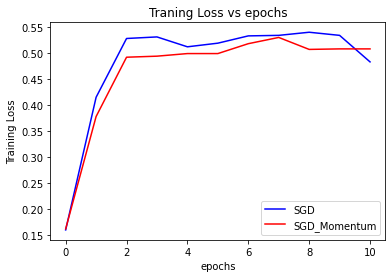

In [10]:
#######################################################################
# Your Code here
#######################################################################
plt.plot(np.arange(11),train_acc_history_SGD,color='b',label='SGD')
plt.plot(np.arange(11),train_acc_history_SGD_Momentum,color='r',label='SGD_Momentum')
plt.xlabel('epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Traning Loss vs epochs')
#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

Report your obervation here:

# 4.2(g) Adding L2 regularization (EECS 504 Only)

Add L2 regularization to the softmax classifier in 4.2(b)

# 4.2(h) Training with L2 regularization (EECS 504 Only)

Train the model again using L2 regularization, using SGD

In [13]:
# initialize model (remember to set the l2 regularization weight > 0)
model_SGD_L2 = SoftmaxClassifier(hidden_dim = 300, weight_scale=1e-2, reg=0.01)

# start training using SGD. The training hyperparameter you choose should be same to the 4.2(c)
model_SGD_L2, train_acc_history_SGD_L2, val_acc_history_SGD_L2 = trainNetwork(
    model_SGD_L2, train_data, 
    learning_rate = learning_rate_SGD,
    lr_decay=lr_decay_SGD, 
    batch_size=batch_size_SGD,
    num_epochs=10, 
    print_every=1000, optimizer = 'SGD')

(Iteration 1 / 6250) loss: 2.760004
(Epoch 0 / 10) train acc: 0.170000; val_acc: 0.164500
(Epoch 1 / 10) train acc: 0.481000; val_acc: 0.426200
(Iteration 1001 / 6250) loss: 1.617095
(Epoch 2 / 10) train acc: 0.535000; val_acc: 0.464300
(Epoch 3 / 10) train acc: 0.556000; val_acc: 0.464600
(Iteration 2001 / 6250) loss: 1.768689
(Epoch 4 / 10) train acc: 0.502000; val_acc: 0.464600
(Iteration 3001 / 6250) loss: 1.596591
(Epoch 5 / 10) train acc: 0.529000; val_acc: 0.464600
(Epoch 6 / 10) train acc: 0.513000; val_acc: 0.464600
(Iteration 4001 / 6250) loss: 1.614995
(Epoch 7 / 10) train acc: 0.508000; val_acc: 0.464600
(Epoch 8 / 10) train acc: 0.508000; val_acc: 0.464600
(Iteration 5001 / 6250) loss: 1.656293
(Epoch 9 / 10) train acc: 0.527000; val_acc: 0.464600
(Iteration 6001 / 6250) loss: 1.525632
(Epoch 10 / 10) train acc: 0.512000; val_acc: 0.464600


In [14]:
# report test accuracy
acc = testNetwork(model_SGD_L2, data['X_test'], data['y_test'])
print("Test accuracy of model_SGD_L2: {}".format(acc))

Test accuracy of model_SGD_L2: 0.4663


# 4.2(i) Plot

Using the train_acc_history and val_acc_history, plot the train & val accuracy versus epochs on one plot for model with and without L2 regularization, using SGD as optimizer. 

Text(0.5, 1.0, 'Traning Loss vs epochs')

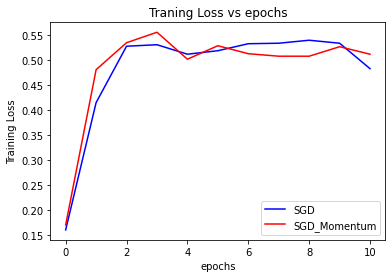

In [15]:
#######################################################################
# TODO: Your Code here
#######################################################################
plt.plot(np.arange(11),train_acc_history_SGD,color='b',label='SGD')
plt.plot(np.arange(11),train_acc_history_SGD_L2,color='r',label='SGD_Momentum')
plt.xlabel('epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Traning Loss vs epochs')

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

# 4.2(j) Tune your own model

Feel free to tune any hyperparameters and choose any optimizer as you want -- just train the best model you can!

In [18]:
#######################################################################
# TODO: Train your own model                                          #
#######################################################################

# initialize model (set reg=0.0 for EECS 442 students)
# input_dim=3072, hidden_dim=300, num_classes=10,
#                  weight_scale=1e-3, reg=0.0
your_model = SoftmaxClassifier(hidden_dim = 500, weight_scale=1e-2,  reg= 0.001)

# train your moodel
your_model, train_acc_history_your_model, val_acc_history_your_model = trainNetwork(
    your_model, train_data, 
    learning_rate = 0.1 ,
    lr_decay=  0.1 , 
    batch_size= 128,
    num_epochs= 10 , 
    print_every=1000, optimizer = 'SGD_Momentum')
#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

(Iteration 1 / 3120) loss: 2.374129
(Epoch 0 / 10) train acc: 0.179000; val_acc: 0.168800
(Epoch 1 / 10) train acc: 0.471000; val_acc: 0.418200
(Epoch 2 / 10) train acc: 0.553000; val_acc: 0.508600
(Epoch 3 / 10) train acc: 0.561000; val_acc: 0.515200
(Iteration 1001 / 3120) loss: 1.276321
(Epoch 4 / 10) train acc: 0.604000; val_acc: 0.515200
(Epoch 5 / 10) train acc: 0.595000; val_acc: 0.515100
(Epoch 6 / 10) train acc: 0.593000; val_acc: 0.515100
(Iteration 2001 / 3120) loss: 1.365748
(Epoch 7 / 10) train acc: 0.600000; val_acc: 0.515100
(Epoch 8 / 10) train acc: 0.579000; val_acc: 0.515100
(Epoch 9 / 10) train acc: 0.572000; val_acc: 0.515100
(Iteration 3001 / 3120) loss: 1.339750
(Epoch 10 / 10) train acc: 0.577000; val_acc: 0.515100


In [19]:
# report test accuracy 
# (Run this code only once when you obtain the highest model in validation set!)
acc = testNetwork(your_model, data['X_test'], data['y_test'])
print("Test accuracy of your model: {}".format(acc))

Test accuracy of your model: 0.5121


# Convert Notebook to PDF

In [1]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

Mounted at /content/drive/


In [21]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS4_FA_2022_Starter_Code.ipynb'
notebookpath = '/content/drive/MyDrive/Colab Notebooks/EECS442-504_PS4_FA_2022.ipynb' 

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>